In [2]:
from qiskit import Aer, IBMQ, execute
from qiskit.providers.aer import noise
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor

In [4]:
#from qiskit import IBMQ
#IBMQ.save_account('TOKEN')

In [5]:
# Load IBMQ account
IBMQ.load_accounts()
IBMQ.backends()

[<IBMQBackend('ibmqx4') from IBMQ()>,
 <IBMQBackend('ibmqx2') from IBMQ()>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ()>,
 <IBMQBackend('ibmq_qasm_simulator') from IBMQ()>]

In [6]:
# The Qiskit Aer device noise module contains two functions to automatically generate a simplified noise model for a real device. 
# This model is generated using the calibration information reported in the BackendProperties of a device.

device = IBMQ.get_backend('ibmq_16_melbourne')
properties = device.properties()

# We must provide the coupling_map for the real device so that the compiler will produce a Qobj for the simulator that 
# will match the compiled experiment that can be executed on the real device.
coupling_map = device.configuration().coupling_map 

C:\Miniconda3\lib\site-packages\marshmallow\schema.py:364: ChangedInMarshmallow3Warning: strict=False is not recommended. In marshmallow 3.0, schemas will always be strict. See https://marshmallow.readthedocs.io/en/latest/upgrading.html#schemas-are-always-strict
  ChangedInMarshmallow3Warning


C:\Miniconda3\lib\site-packages\marshmallow\schema.py:364: ChangedInMarshmallow3Warning: strict=False is not recommended. In marshmallow 3.0, schemas will always be strict. See https://marshmallow.readthedocs.io/en/latest/upgrading.html#schemas-are-always-strict
  ChangedInMarshmallow3Warning


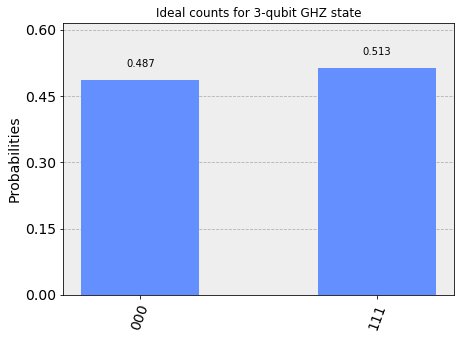

In [7]:
# This is a test circuit where we will prepare a state 1/2 * (|0,0,0> + |1,1,1>).
# The important thing is that we are not simulating noise (not even running on real hardware), so this is the ideal case.

qr = QuantumRegister(3, 'qr')
cr = ClassicalRegister(3, 'cr')
circ = QuantumCircuit(qr, cr)
circ.h(qr[0])
circ.cx(qr[0], qr[1])
circ.cx(qr[1], qr[2])
circ.measure(qr, cr)

simulator = Aer.get_backend('qasm_simulator')

result = execute(circ, simulator).result()
counts = result.get_counts(circ)
plot_histogram(counts, title='Ideal counts for 3-qubit GHZ state')

In [8]:
# Since the devices don't currently provide the gate times for gates we will manually provide them for the gates we are 
# interested in using the optional gate_times argument for basic_device_noise_model.

# List of gate times for ibmq_14_melbourne device
# Note that the None parameter for u1, u2, u3 is because gate times are the same for all qubits
gate_times = [
    ('u1', None, 0), ('u2', None, 100), ('u3', None, 200),
    ('cx', [1, 0], 678), ('cx', [1, 2], 547), ('cx', [2, 3], 721),
    ('cx', [4, 3], 733), ('cx', [4, 10], 721), ('cx', [5, 4], 800),
    ('cx', [5, 6], 800), ('cx', [5, 9], 895), ('cx', [6, 8], 895),
    ('cx', [7, 8], 640), ('cx', [9, 8], 895), ('cx', [9, 10], 800),
    ('cx', [11, 10], 721), ('cx', [11, 3], 634), ('cx', [12, 2], 773),
    ('cx', [13, 1], 2286), ('cx', [13, 12], 1504), ('cx', [], 800)
]

# Construct the noise model from backend properties and custom gate times
noise_model = noise.device.basic_device_noise_model(properties, gate_times=gate_times)
print(noise_model)

NoiseModel:
  Instructions with noise: ['u2', 'u3', 'cx', 'measure']
  Specific qubit errors: [('u2', [1]), ('u2', [2]), ('u2', [4]), ('u2', [11]), ('u2', [7]), ('u2', [9]), ('u2', [12]), ('u2', [10]), ('u2', [13]), ('u2', [0]), ('u2', [8]), ('u2', [6]), ('u2', [3]), ('u2', [5]), ('u3', [1]), ('u3', [2]), ('u3', [4]), ('u3', [11]), ('u3', [7]), ('u3', [9]), ('u3', [12]), ('u3', [10]), ('u3', [13]), ('u3', [0]), ('u3', [8]), ('u3', [6]), ('u3', [3]), ('u3', [5]), ('cx', [1, 0]), ('cx', [11, 12]), ('cx', [13, 12]), ('cx', [9, 8]), ('cx', [7, 8]), ('cx', [5, 9]), ('cx', [11, 10]), ('cx', [2, 3]), ('cx', [4, 3]), ('cx', [12, 2]), ('cx', [13, 1]), ('cx', [9, 10]), ('cx', [6, 8]), ('cx', [5, 4]), ('cx', [4, 10]), ('cx', [11, 3]), ('cx', [1, 2]), ('cx', [5, 6]), ('measure', [1]), ('measure', [2]), ('measure', [4]), ('measure', [11]), ('measure', [7]), ('measure', [9]), ('measure', [12]), ('measure', [10]), ('measure', [13]), ('measure', [0]), ('measure', [8]), ('measure', [6]), ('measure', [3

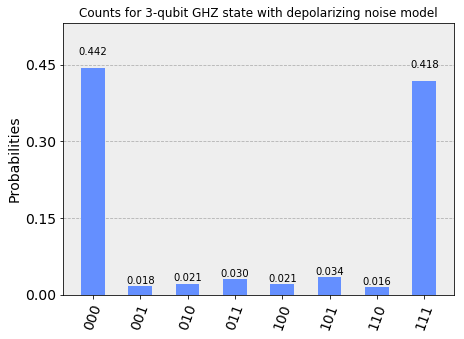

In [9]:
basis_gates = noise_model.basis_gates

simulator = Aer.get_backend('qasm_simulator')

result_noise = execute(circ, simulator, 
                       noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates).result()
counts_noise = result_noise.get_counts(circ)
plot_histogram(counts_noise, title="Counts for 3-qubit GHZ state with depolarizing noise model")

In [10]:
# Now let's compare this with the result obtained with a real device!

job_device = execute(circ, device)
job_monitor(job_device)

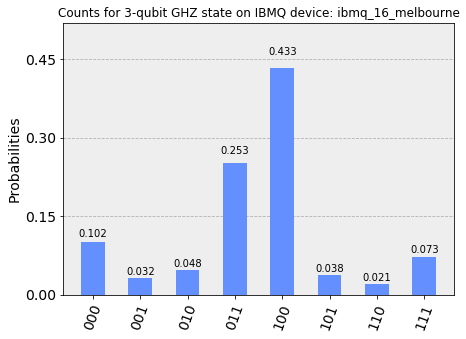

In [11]:
result_device = job_device.result()
counts_device = result_device.get_counts(0)
plot_histogram(counts_device, title='Counts for 3-qubit GHZ state on IBMQ device: {}'.format(device.name()))